# Explainable AI for Object Detection with YOLOv8 and EigenCAM

In [ ]:
#!/usr/bin/env python
# -*-coding:utf-8 -*-
"""
  ████
██    ██   Datature
  ██  ██   Powering Breakthrough AI
    ██
 
@File    :   eigencam_yolov8_od.ipynb
@Author  :   Wei Loon Cheng
@Version :   1.0
@Contact :   hello@datature.io
@License :   Apache License 2.0
@Desc    :   Explainable AI for Object Detection with YOLOv8 and EigenCAM
"""

### Introduction

This notebook serves as an example on how to understand your deep learning object detection model using [EigenCAM](https://arxiv.org/abs/2008.00299). EigenCAM is a gradient-free method that visualizes the principle components of the learned features/representations from the convolutional layers, without the need to modify layers or retrain models.

### Install prerequisites

In [1]:
%pip install datature
%pip install dill
%pip install ttach
%pip install ultralytics
%pip install torch
%pip install wget

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com

[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com

[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com

[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com

[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated pa

In [2]:
import os
from zipfile import ZipFile

import cv2
import datature
import matplotlib.pyplot as plt
import numpy as np
import wget
from ultralytics import YOLO
from yolov8_cam.eigen_cam import EigenCAM
from yolov8_cam.utils.image import show_cam_on_image

/home/cwlroda/.virtualenvs/script-library/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load YOLOv8-Nano Object Detection Model

The sample YOLOv8 model used to show the visualization results in the following cells is a red blood cell detector trained on [Datature Nexus](https://www.datature.io/nexus). We use Datature Python SDK to export the model and download it to the local filesystem.

You can load your own YOLOv8 model trained on Datature Nexus by providing your [project secret key](https://dash.readme.com/project/datature/v1.0/docs/hub-and-api) and modifying the workflow title.

In [3]:
datature.secret_key = "YOUR_PROJECT_SECRET_KEY"
workflow_title = "YOUR_WORKFLOW_TITLE"

## Obtain an artifact id from Nexus, in this case, we assume that there is only one artifact
all_artifacts = datature.Artifact.list()
artifact = [
    artifact for artifact in all_artifacts
    if artifact["flow_title"] == workflow_title
][-1]
artifact_id = artifact["id"]

# Export a model to the specified model format for specified artifact id
# If model is already exported, then catch the error
try:
    datature.Artifact.export_model(artifact_id, "pytorch")
except Exception as err:
    print(err)

('Internal Server Error', {'code': 'ConflictError', 'message': 'Model has already been exported.'})


In [4]:
# Retrieve model metadata containing the download url
all_models = datature.Artifact.list_exported(artifact_id)
model_metadata = [
    model for model in all_models if model["format"] == "pytorch"
][-1]

# Download and unzip the model
model_dir = "models/"
model_zipfile = wget.download(model_metadata["download"]["url"], model_dir)
with ZipFile(model_zipfile, 'r') as zObject:
    model_filename = zObject.namelist()[-1]
    zObject.extractall(path=model_dir)

In [5]:
model_filename = [
    filename for filename in os.listdir(model_dir)
    if filename.endswith("yolov8n.pt")
][-1]
print(model_filename)
model = YOLO(os.path.join(model_dir, model_filename))

datature-yolov8n.pt


### Read and preprocess image

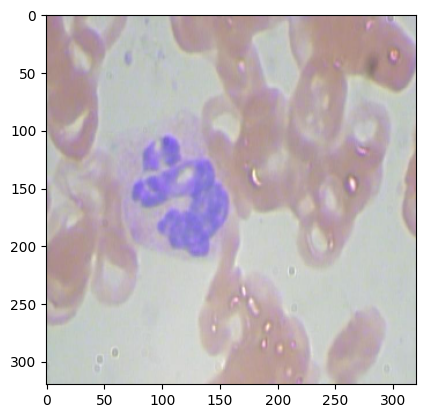

In [6]:
img = cv2.imread('images/rbc.png')
img = cv2.resize(img, (320, 320))
rgb_img = img.copy()
img = np.float32(img) / 255
plt.imshow(cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
plt.show()

### Select target layer for feature extraction

Different model architectures tend to utilize different layer activations, so you will need to adjust accordingly if you are using a custom model.

In [7]:
target_layers = [model.model.model[-3]]


0: 320x320 14 RBCs, 1 WBC, 1 Platelets, 36.5ms
Speed: 3.8ms preprocess, 36.5ms inference, 1.3ms postprocess per image at shape (1, 3, 320, 320)


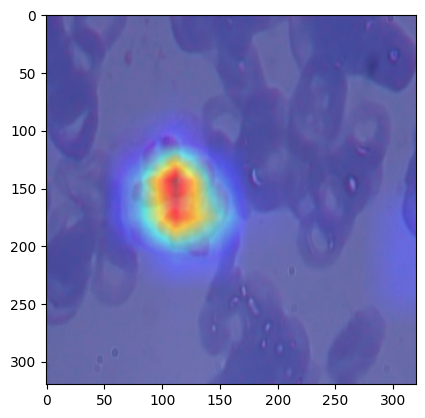

In [8]:
cam = EigenCAM(model, target_layers,task='od')
grayscale_cam = cam(
    rgb_img,
    eigen_smooth=True,
)[0, :, :]
cam_image = show_cam_on_image(img, grayscale_cam, use_rgb=True)
plt.imshow(cam_image)
plt.show()